Using device: cuda
Loading PAMAP2 dataset...
Found 14 subject files. Processing...
  Processing subject101...
  Processing subject102...
  Processing subject103...
  Processing subject104...
  Processing subject105...
  Processing subject106...
  Processing subject107...
  Processing subject108...
  Processing subject109...
  Processing subject101...
  Processing subject105...
  Processing subject106...
  Processing subject108...
  Processing subject109...
PAMAP2 - X_sequences shape: (38843, 100, 18)
PAMAP2 - y shape: (38843,), unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Dataset info:
  Features: 18
  Sequence Length: 100
  Classes: 12
  Samples: 38843

Split sizes:
  Train: (22139, 100, 18)
  Val: (1166, 100, 18)
  Test: (15538, 100, 18)

Running: Linear Interpolation - Missing Rate: 10%
Creating missing masks...
Performing Linear Interpolation imputation...
Training classifier...
  Epoch 10/100, Train Loss: 0.1534, Val Acc: 95.20%, LR: 0.000976
  Epoch 20/100, Train Loss: 0

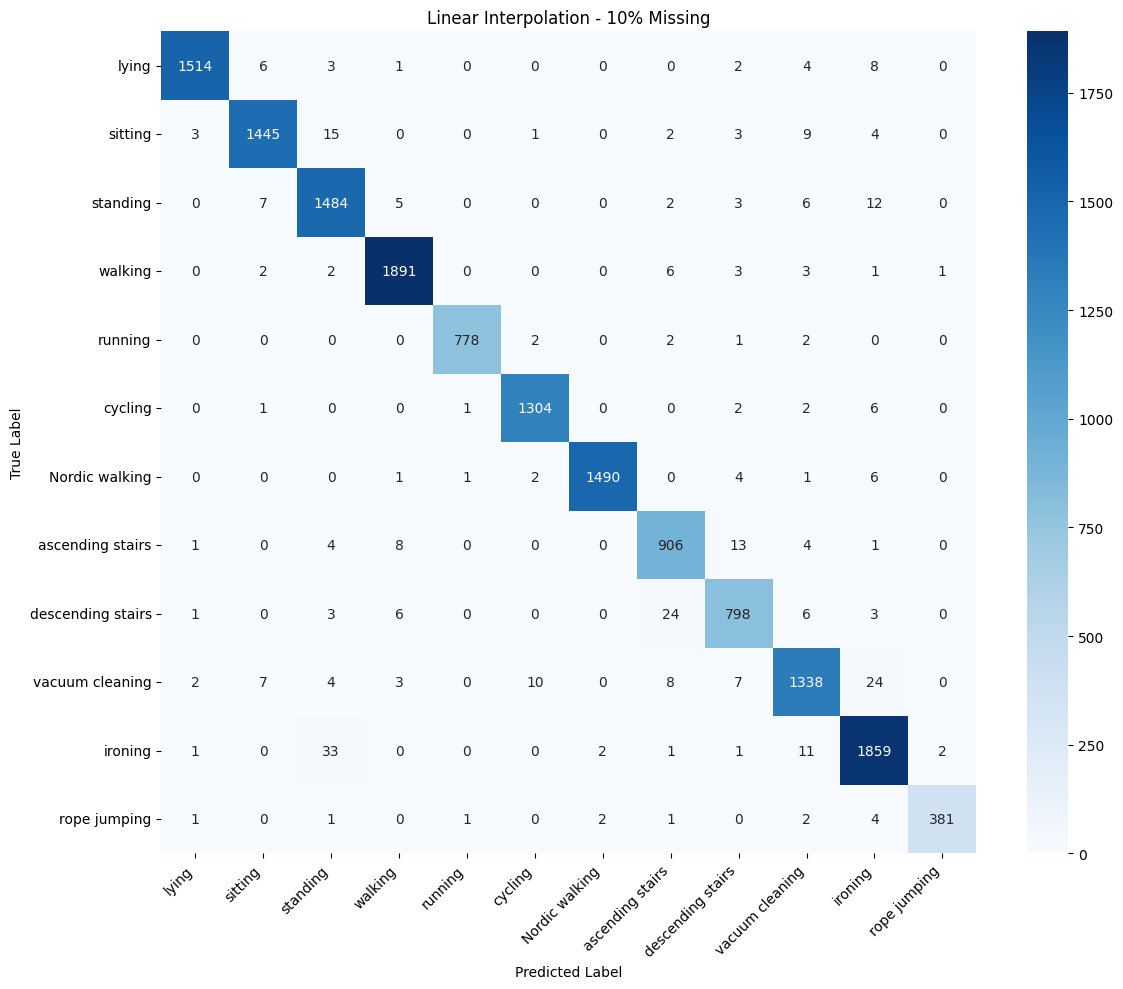


Running: Mean Imputation - Missing Rate: 10%
Creating missing masks...
Performing Mean Imputation imputation...
Training classifier...
  Epoch 10/100, Train Loss: 0.1614, Val Acc: 94.34%, LR: 0.000976
  Epoch 20/100, Train Loss: 0.0890, Val Acc: 95.45%, LR: 0.000905
  Epoch 30/100, Train Loss: 0.0583, Val Acc: 97.00%, LR: 0.000794
  Epoch 40/100, Train Loss: 0.0371, Val Acc: 97.08%, LR: 0.000655
  Epoch 50/100, Train Loss: 0.0308, Val Acc: 97.60%, LR: 0.000501
  Epoch 60/100, Train Loss: 0.0187, Val Acc: 97.51%, LR: 0.000346
  Epoch 70/100, Train Loss: 0.0154, Val Acc: 97.94%, LR: 0.000207
  Early stopping at epoch 72
Evaluating...

Results: Mean Imputation - 10%
Accuracy:   97.63%
Precision:  0.9764
Recall:     0.9763
F1-Score:   0.9763
Parameters: 0.08M
FLOPs:      2.88M
Inference:  0.64ms



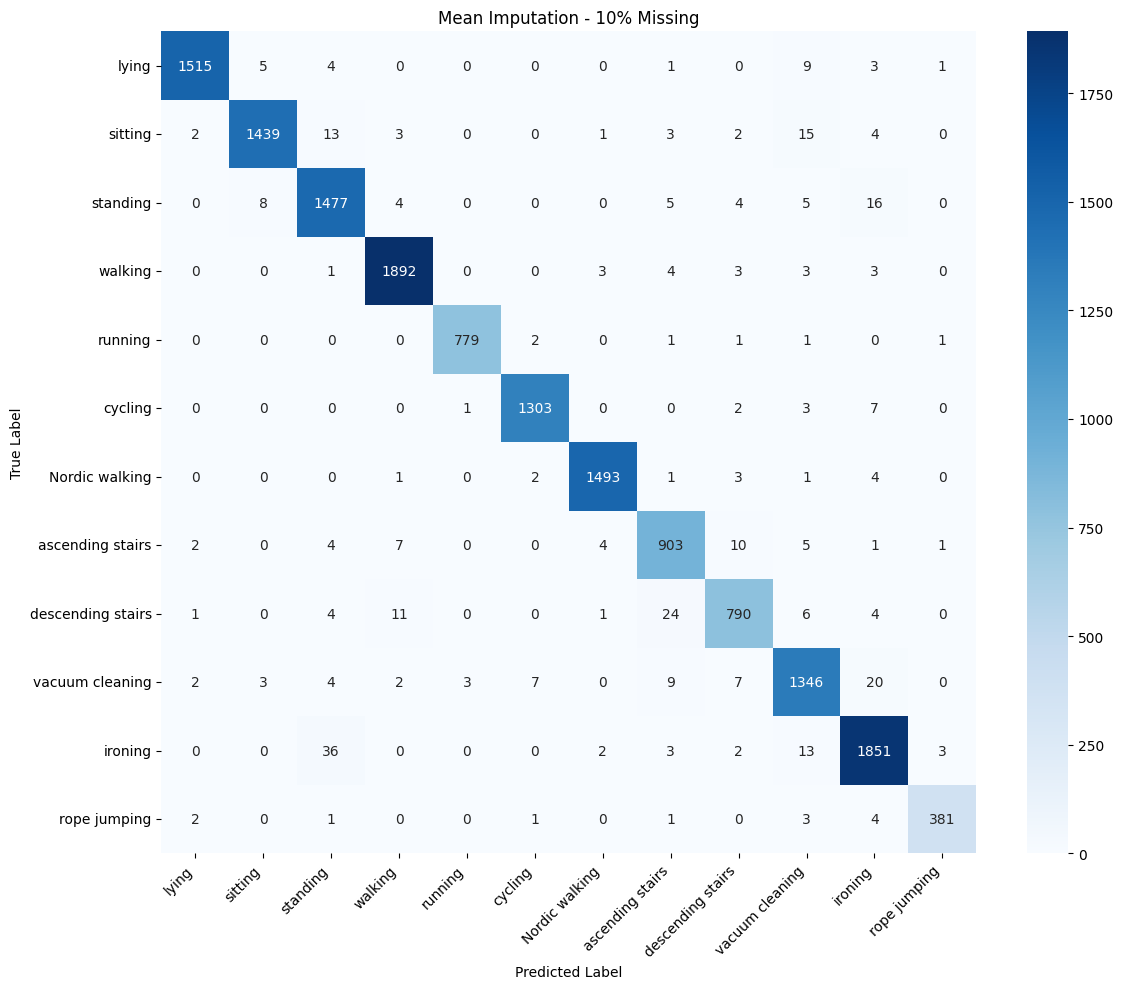


Running: SAITS - Missing Rate: 10%
Creating missing masks...
Performing SAITS imputation...
Training SAITS...
  Epoch 10/100, Loss: -12.2824
  Epoch 20/100, Loss: -13.4666


KeyboardInterrupt: 

In [8]:
!pip install thop ptflops

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile
import time
from collections import Counter
import os
import glob
from sklearn.preprocessing import StandardScaler
from torch.utils.checkpoint import checkpoint
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def load_pamap2_data(dataset_dir="/content/drive/MyDrive/HAR_Dataset/PAMAP2"):
    print("Loading PAMAP2 dataset...")
    file_paths = sorted(glob.glob(os.path.join(dataset_dir, 'Protocol', 'subject*.dat')))
    optional_path = os.path.join(dataset_dir, 'Optional')
    if os.path.exists(optional_path):
        file_paths += sorted(glob.glob(os.path.join(optional_path, 'subject*.dat')))
    if not file_paths:
        print("Error: No subject files found")
        return None, None, None
    print(f"Found {len(file_paths)} subject files. Processing...")

    activity_labels = [
        "lying", "sitting", "standing", "walking", "running", "cycling",
        "Nordic walking", "ascending stairs", "descending stairs",
        "vacuum cleaning", "ironing", "rope jumping"
    ]

    label_to_activity_idx = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
        12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }

    all_windows = []
    all_labels = []
    window_size = 100
    step = 50

    for file_path in file_paths:
        subject_id = os.path.basename(file_path).split('.')[0]
        print(f"  Processing {subject_id}...")
        try:
            df = pd.read_csv(file_path, sep='\s+', header=None, na_values='NaN')
            df_cleaned = df.fillna(method='ffill').fillna(method='bfill')

            if df_cleaned.empty:
                continue

            labels = df_cleaned.iloc[:, 1].values.astype(int)
            hand_imu = list(range(5,11))
            chest_imu = list(range(14,20))
            ankle_imu = list(range(23,29))
            all_sensor_cols = hand_imu + chest_imu + ankle_imu

            if df_cleaned.shape[1] < max(all_sensor_cols) + 1:
                continue

            features = df_cleaned.iloc[:, all_sensor_cols].values.astype(np.float32)
            valid_indices = np.where(np.isin(labels, list(label_to_activity_idx.keys())))[0]

            if len(valid_indices) == 0:
                continue

            features = features[valid_indices, :]
            labels = labels[valid_indices]

            if len(features) < window_size:
                continue

            start = 0
            while start + window_size <= len(features):
                window_data = features[start : start + window_size, :]
                window_labels_raw = labels[start : start + window_size]
                most_common_label = Counter(window_labels_raw).most_common(1)[0][0]

                if most_common_label in label_to_activity_idx:
                    all_windows.append(window_data)
                    all_labels.append(label_to_activity_idx[most_common_label])

                start += step
        except Exception as e:
            print(f"    Error processing {subject_id}: {e}")

    if not all_windows:
        print("Error: No windows created")
        return None, None, None

    X_windowed = np.array(all_windows, dtype=np.float32)
    y_encoded = np.array(all_labels, dtype=int)

    scaler = StandardScaler()
    X_windowed_flat = X_windowed.reshape(X_windowed.shape[0], -1)
    X_windowed_flat = scaler.fit_transform(X_windowed_flat)
    X_windowed = X_windowed_flat.reshape(X_windowed.shape)

    print(f"PAMAP2 - X_sequences shape: {X_windowed.shape}")
    print(f"PAMAP2 - y shape: {y_encoded.shape}, unique labels: {np.unique(y_encoded)}")

    return X_windowed, y_encoded, activity_labels


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class LocalWindowAttention(nn.Module):
    def __init__(self, d_model, n_heads, window_size=10, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.window_size = window_size

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(self.d_k)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        mask = torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool)
        for i in range(seq_len):
            start = max(0, i - self.window_size // 2)
            end = min(seq_len, i + self.window_size // 2 + 1)
            mask[i, start:end] = False

        mask = mask.unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(output)

        return output, attn_weights


class CrossAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = np.sqrt(self.d_k)

    def forward(self, query, key_value):
        batch_size, seq_len, _ = query.size()

        Q = self.W_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key_value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(key_value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(output)

        return output, attn_weights


class DMSABlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ffn, n_layers, window_size=10, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'attn': LocalWindowAttention(d_model, n_heads, window_size, dropout),
                'norm1': nn.LayerNorm(d_model),
                'ffn': nn.Sequential(
                    nn.Linear(d_model, d_ffn),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(d_ffn, d_model),
                    nn.Dropout(dropout)
                ),
                'norm2': nn.LayerNorm(d_model)
            }) for _ in range(n_layers)
        ])

    def forward(self, x):
        attn_weights_list = []
        for layer in self.layers:
            if self.training:
                attn_out, attn_weights = checkpoint(layer['attn'], x, use_reentrant=False)
                x = layer['norm1'](x + attn_out)

                x_ffn_in = x
                ffn_out = checkpoint(layer['ffn'], x_ffn_in, use_reentrant=False)
                x = layer['norm2'](x_ffn_in + ffn_out)

                attn_weights_list.append(attn_weights.detach())
            else:
                attn_out, attn_weights = layer['attn'](x)
                x = layer['norm1'](x + attn_out)
                ffn_out = layer['ffn'](x)
                x = layer['norm2'](x + ffn_out)
                attn_weights_list.append(attn_weights)

        return x, attn_weights_list


class MaskAwareGating(nn.Module):
    def __init__(self, d_model, n_features):
        super().__init__()
        self.gate_net = nn.Sequential(
            nn.Linear(n_features + d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, n_features),
            nn.Sigmoid()
        )

    def forward(self, M, attn_stat):
        gate_input = torch.cat([M, attn_stat], dim=-1)
        eta = self.gate_net(gate_input)
        return eta


class SAITS(nn.Module):
    def __init__(self, n_features, d_model=256, n_heads=4, d_ffn=128, n_layers=2, window_size=10, dropout=0.1, n_iterations=2):
        super().__init__()
        self.n_features = n_features
        self.d_model = d_model
        if n_iterations != 2:
            raise ValueError("This modified SAITS implementation is hardcoded for n_iterations=2")

        self.input_projection = nn.Linear(n_features * 2, d_model)
        self.pos_encoding = PositionalEncoding(d_model)

        self.shared_dmsa = DMSABlock(d_model, n_heads, d_ffn, n_layers, window_size, dropout)

        self.cross_attn = CrossAttention(d_model, n_heads, dropout)
        self.cross_norm = nn.LayerNorm(d_model)

        self.output_projection_mean = nn.Linear(d_model, n_features)
        self.output_projection_logvar = nn.Linear(d_model, n_features)

        self.mask_gate = MaskAwareGating(d_model, n_features)

    def forward(self, X, M):
        batch_size, seq_len, n_features = X.size()
        X_masked = X * M

        # Iteration 1
        input_1_iter1 = torch.cat([X_masked, M], dim=-1)
        embed_1_iter1 = self.input_projection(input_1_iter1)
        embed_1_iter1 = self.pos_encoding(embed_1_iter1)
        repr_1_iter1, _ = self.shared_dmsa(embed_1_iter1)

        X_tilde_1_mean_iter1 = self.output_projection_mean(repr_1_iter1)
        X_tilde_1_logvar_iter1 = self.output_projection_logvar(repr_1_iter1)

        X_prime_iter1 = M * X + (1 - M) * X_tilde_1_mean_iter1
        input_2_iter1 = torch.cat([X_prime_iter1, M], dim=-1)
        embed_2_iter1 = self.input_projection(input_2_iter1)
        embed_2_iter1 = self.pos_encoding(embed_2_iter1)

        cross_out_iter1, _ = self.cross_attn(embed_2_iter1, repr_1_iter1)
        embed_2_iter1 = self.cross_norm(embed_2_iter1 + cross_out_iter1)

        repr_2_iter1, _ = self.shared_dmsa(embed_2_iter1)
        X_tilde_2_mean_iter1 = self.output_projection_mean(repr_2_iter1)
        X_tilde_2_logvar_iter1 = self.output_projection_logvar(repr_2_iter1)

        # Iteration 2
        X_prev_iter2 = M * X + (1 - M) * X_tilde_1_mean_iter1
        input_1_iter2 = torch.cat([X_prev_iter2, M], dim=-1)

        embed_1_iter2 = self.input_projection(input_1_iter2)
        embed_1_iter2 = self.pos_encoding(embed_1_iter2)

        repr_1_iter2, _ = self.shared_dmsa(embed_1_iter2)
        X_tilde_1_mean = self.output_projection_mean(repr_1_iter2)
        X_tilde_1_logvar = self.output_projection_logvar(repr_1_iter2)

        X_prime_iter2 = M * X + (1 - M) * X_tilde_1_mean
        input_2_iter2 = torch.cat([X_prime_iter2, M], dim=-1)
        embed_2_iter2 = self.input_projection(input_2_iter2)
        embed_2_iter2 = self.pos_encoding(embed_2_iter2)

        cross_out_iter2, _ = self.cross_attn(embed_2_iter2, repr_1_iter2)
        embed_2_iter2 = self.cross_norm(embed_2_iter2 + cross_out_iter2)

        repr_2_iter2, attn_weights_list = self.shared_dmsa(embed_2_iter2)
        X_tilde_2_mean = self.output_projection_mean(repr_2_iter2)
        X_tilde_2_logvar = self.output_projection_logvar(repr_2_iter2)

        # Gating
        eta = self.mask_gate(M, repr_2_iter2)

        X_tilde_3_mean = (1 - eta) * X_tilde_1_mean + eta * X_tilde_2_mean
        X_tilde_3_logvar = (1 - eta) * X_tilde_1_logvar + eta * X_tilde_2_logvar

        X_completed = M * X + (1 - M) * X_tilde_3_mean

        return X_completed, X_tilde_1_mean, X_tilde_2_mean, X_tilde_3_mean, X_tilde_1_logvar_iter1, X_tilde_2_logvar_iter1, X_tilde_3_logvar


def create_missing_mask(X, missing_rate=0.3):
    mask = torch.ones_like(X)
    random_mask = torch.rand_like(X) > missing_rate
    mask = mask * random_mask.float()
    return mask


def linear_imputation(X, M):
    X_imputed = X.clone()
    batch_size, seq_len, n_features = X.shape

    for b in range(batch_size):
        for f in range(n_features):
            mask = M[b, :, f].cpu().numpy()
            values = X[b, :, f].cpu().numpy()

            observed = np.where(mask == 1)[0]
            missing = np.where(mask == 0)[0]

            if len(observed) > 1 and len(missing) > 0:
                values[missing] = np.interp(missing, observed, values[observed])
                X_imputed[b, :, f] = torch.tensor(values, device=X.device)

    return X_imputed


def mean_imputation(X, M):
    X_imputed = X.clone()

    for b in range(X.shape[0]):
        for f in range(X.shape[2]):
            observed_vals = X[b, M[b, :, f] == 1, f]
            if len(observed_vals) > 0:
                mean_val = observed_vals.mean()
                X_imputed[b, M[b, :, f] == 0, f] = mean_val

    return X_imputed


class CNNClassifier(nn.Module):
    def __init__(self, n_features, n_classes, dropout=0.1):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Dropout(dropout),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Dropout(dropout),

            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.GELU()
        )

        self.pool_flatten = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.classifier = nn.Linear(128, n_classes)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        x = self.feature_extractor(x)
        x = self.pool_flatten(x)
        return x

    def forward(self, x, psi=None):
        features = self.extract_features(x)
        return self.classifier(features)


class ImputedDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def train_saits(model, train_loader, n_epochs=100, lr=1e-3, missing_rate=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(n_epochs):
        total_loss = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            M_orig = torch.ones_like(X_batch)
            M_artificial = create_missing_mask(X_batch, missing_rate=missing_rate)
            I = M_orig - M_artificial

            X_masked = X_batch * M_artificial

            X_completed, X_tilde_1_mean, X_tilde_2_mean, X_tilde_3_mean, X_tilde_1_logvar, X_tilde_2_logvar, X_tilde_3_logvar = model(X_masked, M_artificial)

            sigma_1 = torch.exp(0.5 * X_tilde_1_logvar)
            sigma_2 = torch.exp(0.5 * X_tilde_2_logvar)
            sigma_3 = torch.exp(0.5 * X_tilde_3_logvar)

            eps = 1e-6

            ort_loss_1 = (torch.abs(X_tilde_1_mean - X_batch) * M_artificial / (sigma_1 + eps) + X_tilde_1_logvar * M_artificial).sum() / (M_artificial.sum() + eps)
            ort_loss_2 = (torch.abs(X_tilde_2_mean - X_batch) * M_artificial / (sigma_2 + eps) + X_tilde_2_logvar * M_artificial).sum() / (M_artificial.sum() + eps)
            ort_loss_3 = (torch.abs(X_tilde_3_mean - X_batch) * M_artificial / (sigma_3 + eps) + X_tilde_3_logvar * M_artificial).sum() / (M_artificial.sum() + eps)
            ort_loss = (ort_loss_1 + ort_loss_2 + ort_loss_3) / 3

            mit_loss = (torch.abs(X_tilde_3_mean - X_batch) * I / (sigma_3 + eps) + X_tilde_3_logvar * I).sum() / (I.sum() + eps)

            loss = ort_loss + mit_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader):.4f}")


def train_classifier(model, train_loader, val_loader, n_epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)

    best_acc = 0
    patience = 20
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                _, predicted = outputs.max(1)
                total += y_batch.size(0)
                correct += predicted.eq(y_batch).sum().item()

        val_acc = 100. * correct / total
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc:.2f}%, LR: {current_lr:.6f}")

        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break

    return best_acc


def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, precision, recall, f1, cm


def impute_in_batches(model, X_masked, M, batch_size=256):
    model.eval()
    imputed_list = []

    dataset = TensorDataset(X_masked, M)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for X_batch, M_batch in loader:
            X_batch, M_batch = X_batch.to(device), M_batch.to(device)
            X_completed, _, _, _, _, _, _ = model(X_batch, M_batch)
            imputed_list.append(X_completed.cpu())

    return torch.cat(imputed_list, dim=0)


def compute_model_stats(model, input_shape=(100, 18)):
    try:
        device = next(model.parameters()).device
        dummy_input = torch.randn(1, *input_shape).to(device)
        model.eval()

        with torch.no_grad():
            classifier_original = model.classifier
            model.classifier = nn.Identity()
            macs_backbone, params_backbone = profile(model, inputs=(dummy_input,), verbose=False)

            model.classifier = classifier_original
            features = model.extract_features(dummy_input)
            macs_cls, params_cls = profile(model.classifier, inputs=(features,), verbose=False)

        total_macs_m = (macs_backbone + macs_cls) / 1e6
        total_params_m = (params_backbone + params_cls) / 1e6

        return total_params_m, total_macs_m
    except Exception as e:
        print(f"Error computing model stats: {e}")
        return 0.0, 0.0


def measure_inference_time(model, input_size=(1, 100, 18), device='cuda', n_runs=100, warmup=10):
    try:
        model.eval()
        inputs = torch.randn(input_size).to(device)

        with torch.inference_mode():
            for _ in range(warmup):
                _ = model(inputs)

        if device == 'cuda' and torch.cuda.is_available():
            torch.cuda.synchronize()

        start = time.time()
        with torch.inference_mode():
            for _ in range(n_runs):
                _ = model(inputs)

        if device == 'cuda' and torch.cuda.is_available():
            torch.cuda.synchronize()

        end = time.time()
        return (end - start) / n_runs * 1000
    except Exception as e:
        print(f"Error measuring inference time: {e}")
        return 0.0


def plot_confusion_matrix(cm, activity_labels, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=activity_labels, yticklabels=activity_labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def run_experiment(X_train, X_val, X_test, y_train, y_val, y_test,
                   imputation_method, activity_labels, n_features, n_classes, missing_rate):
    print(f"\n{'='*60}")
    print(f"Running: {imputation_method} - Missing Rate: {missing_rate*100:.0f}%")
    print(f"{'='*60}")

    print("Creating missing masks...")
    M_train = create_missing_mask(torch.FloatTensor(X_train), missing_rate=missing_rate)
    M_val = create_missing_mask(torch.FloatTensor(X_val), missing_rate=missing_rate)
    M_test = create_missing_mask(torch.FloatTensor(X_test), missing_rate=missing_rate)

    X_train_masked = torch.FloatTensor(X_train) * M_train
    X_val_masked = torch.FloatTensor(X_val) * M_val
    X_test_masked = torch.FloatTensor(X_test) * M_test

    print(f"Performing {imputation_method} imputation...")
    if imputation_method == "Linear Interpolation":
        X_train_imputed = linear_imputation(X_train_masked, M_train).numpy()
        X_val_imputed = linear_imputation(X_val_masked, M_val).numpy()
        X_test_imputed = linear_imputation(X_test_masked, M_test).numpy()

    elif imputation_method == "Mean Imputation":
        X_train_imputed = mean_imputation(X_train_masked, M_train).numpy()
        X_val_imputed = mean_imputation(X_val_masked, M_val).numpy()
        X_test_imputed = mean_imputation(X_test_masked, M_test).numpy()

    elif imputation_method == "SAITS":
        saits_model = SAITS(n_features=n_features, d_model=256, n_heads=4,
                           d_ffn=128, n_layers=2, window_size=10, dropout=0.1, n_iterations=2).to(device)

        train_dataset = ImputedDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        print("Training SAITS...")
        train_saits(saits_model, train_loader, n_epochs=100, lr=1e-3, missing_rate=missing_rate)

        saits_model.eval()
        imputation_batch_size = 256

        print("Imputing train set in batches...")
        X_train_imputed = impute_in_batches(saits_model, X_train_masked, M_train, batch_size=imputation_batch_size).numpy()
        print("Imputing val set in batches...")
        X_val_imputed = impute_in_batches(saits_model, X_val_masked, M_val, batch_size=imputation_batch_size).numpy()
        print("Imputing test set in batches...")
        X_test_imputed = impute_in_batches(saits_model, X_test_masked, M_test, batch_size=imputation_batch_size).numpy()

    print("Training classifier...")
    classifier = CNNClassifier(n_features, n_classes, dropout=0.1).to(device)

    train_dataset = ImputedDataset(X_train_imputed, y_train)
    val_dataset = ImputedDataset(X_val_imputed, y_val)
    test_dataset = ImputedDataset(X_test_imputed, y_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    best_val_acc = train_classifier(classifier, train_loader, val_loader, n_epochs=100, lr=1e-3)

    print("Evaluating...")
    acc, precision, recall, f1, cm = evaluate(classifier, test_loader)

    seq_len = X_train.shape[1]

    params, flops = compute_model_stats(classifier, input_shape=(seq_len, n_features))
    inference_time = measure_inference_time(classifier, input_size=(1, seq_len, n_features),
                                           device=str(device), n_runs=100)

    print(f"\n{'='*60}")
    print(f"Results: {imputation_method} - {missing_rate*100:.0f}%")
    print(f"{'='*60}")
    print(f"Accuracy:   {acc*100:.2f}%")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1-Score:   {f1:.4f}")
    print(f"Parameters: {params:.2f}M")
    print(f"FLOPs:      {flops:.2f}M")
    print(f"Inference:  {inference_time:.2f}ms")
    print(f"{'='*60}\n")

    plot_confusion_matrix(cm, activity_labels, f"{imputation_method} - {missing_rate*100:.0f}% Missing")

    return {
        'Missing Rate': f"{missing_rate*100:.0f}%",
        'Method': imputation_method,
        'Accuracy': acc * 100,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Parameters (M)': params,
        'FLOPs (M)': flops,
        'Inference (ms)': inference_time
    }


def main():
    X, y, activity_labels = load_pamap2_data()

    if X is None:
        print("Failed to load data")
        return

    n_features = X.shape[2]
    seq_len = X.shape[1]
    n_classes = len(activity_labels)

    print(f"\nDataset info:")
    print(f"  Features: {n_features}")
    print(f"  Sequence Length: {seq_len}")
    print(f"  Classes: {n_classes}")
    print(f"  Samples: {len(X)}")

    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.05, random_state=42, stratify=y_temp)

    print(f"\nSplit sizes:")
    print(f"  Train: {X_train.shape}")
    print(f"  Val: {X_val.shape}")
    print(f"  Test: {X_test.shape}")

    results = []
    missing_rates = [0.1, 0.2, 0.3, 0.5]
    methods = ["Linear Interpolation", "Mean Imputation", "SAITS"]

    for missing_rate in missing_rates:
        for method in methods:
            result = run_experiment(X_train, X_val, X_test, y_train, y_val, y_test,
                                  method, activity_labels, n_features, n_classes, missing_rate)
            results.append(result)

    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)

    results_df = pd.DataFrame(results)

    try:
        from IPython.display import display
        display(results_df)
    except ImportError:
        print(results_df)


    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Parameters (M)', 'FLOPs (M)']
    axes_flat = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes_flat[idx]

        pivot_df = results_df.pivot(index='Method', columns='Missing Rate', values=metric)
        pivot_df.plot(kind='bar', ax=ax)

        ax.set_title(metric, fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.legend(title='Missing Rate')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\nExperiment completed!")


if __name__ == "__main__":
    main()
